In [1]:
import numpy as np
import pandas as pd
import featuretools as ft
import time
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load the track information (mini version)

tf_df = pd.read_csv('../data/raw/data/track_features/tf_mini.csv')
log_df = pd.read_csv('../data/raw/data/training_set/log_mini.csv')

In [3]:
# perform some data cleaning/re-coding as described in 2_mini_EDA

tf_df_dummy = pd.get_dummies(tf_df, columns=['key','time_signature','mode'])
log_df_dummy = pd.get_dummies(log_df.drop(columns = ['session_length',  'hist_user_behavior_reason_end', 'hist_user_behavior_n_seekfwd','hist_user_behavior_n_seekback']), columns=['hist_user_behavior_reason_start', 'context_type'])


In [4]:
df = log_df_dummy.merge(tf_df_dummy, left_on = 'track_id_clean', right_on = 'track_id')
df.sort_values(by = ['session_id', 'session_position'],inplace = True)
df.head().T

,0,45,50,327,353
session_id,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e
session_position,1,2,3,4,5
track_id_clean,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,t_64f3743c-f624-46bb-a579-0f3f9a07a123
skip_1,False,False,False,False,False
skip_2,False,False,False,False,False
...,...,...,...,...,...
time_signature_3,0,0,0,0,0
time_signature_4,1,1,1,1,1
time_signature_5,0,0,0,0,0
mode_major,1,0,1,1,1


In [5]:
df.columns

Index(['session_id', 'session_position', 'track_id_clean', 'skip_1', 'skip_2',
       'skip_3', 'not_skipped', 'context_switch', 'no_pause_before_play',
       'short_pause_before_play', 'long_pause_before_play',
       'hist_user_behavior_is_shuffle', 'hour_of_day', 'date', 'premium',
       'hist_user_behavior_reason_start_appload',
       'hist_user_behavior_reason_start_backbtn',
       'hist_user_behavior_reason_start_clickrow',
       'hist_user_behavior_reason_start_endplay',
       'hist_user_behavior_reason_start_fwdbtn',
       'hist_user_behavior_reason_start_playbtn',
       'hist_user_behavior_reason_start_remote',
       'hist_user_behavior_reason_start_trackdone',
       'hist_user_behavior_reason_start_trackerror', 'context_type_catalog',
       'context_type_charts', 'context_type_editorial_playlist',
       'context_type_personalized_playlist', 'context_type_radio',
       'context_type_user_collection', 'track_id', 'duration', 'release_year',
       'us_popularity_es

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167880 entries, 0 to 134498
Data columns (total 76 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   session_id                                  167880 non-null  object 
 1   session_position                            167880 non-null  int64  
 2   track_id_clean                              167880 non-null  object 
 3   skip_1                                      167880 non-null  bool   
 4   skip_2                                      167880 non-null  bool   
 5   skip_3                                      167880 non-null  bool   
 6   not_skipped                                 167880 non-null  bool   
 7   context_switch                              167880 non-null  int64  
 8   no_pause_before_play                        167880 non-null  int64  
 9   short_pause_before_play                     167880 non-null  int64  
 

In [16]:
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167880 entries, 0 to 134498
Data columns (total 76 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   session_id                                  167880 non-null  object        
 1   session_position                            167880 non-null  int64         
 2   track_id_clean                              167880 non-null  object        
 3   skip_1                                      167880 non-null  bool          
 4   skip_2                                      167880 non-null  bool          
 5   skip_3                                      167880 non-null  bool          
 6   not_skipped                                 167880 non-null  bool          
 7   context_switch                              167880 non-null  int64         
 8   no_pause_before_play                        167880 non-null  int64        

In [6]:

import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

#from library.sb_utils import save_file

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['not_skipped', 'skip_1', 'skip_2', 'skip_3', 'session_id','track_id_clean','track_id','date']), 
                                                    df['not_skipped'], test_size=0.2, 
                                                    random_state=47,stratify=df['not_skipped'])

In [34]:
print('X_train.shape: ',X_train.shape)
print('X_test.shape: ',X_test.shape)
print('y_train.shape: ',y_train.shape)
print('y_test.shape: ',y_test.shape)

X_train.shape:  (134304, 68)
X_test.shape:  (33576, 68)
y_train.shape:  (134304,)
y_test.shape:  (33576,)


In [35]:
RF = RandomForestClassifier(random_state=23)

RF.fit(X_train, y_train)

RandomForestClassifier(random_state=23)

In [37]:
score_train = RF.score(X_train,y_train)
score_test = RF.score(X_test,y_test)
print('score_train',score_train)
print('score_test',score_test)

score_train 0.9972822849654515
score_test 0.7925601620204908


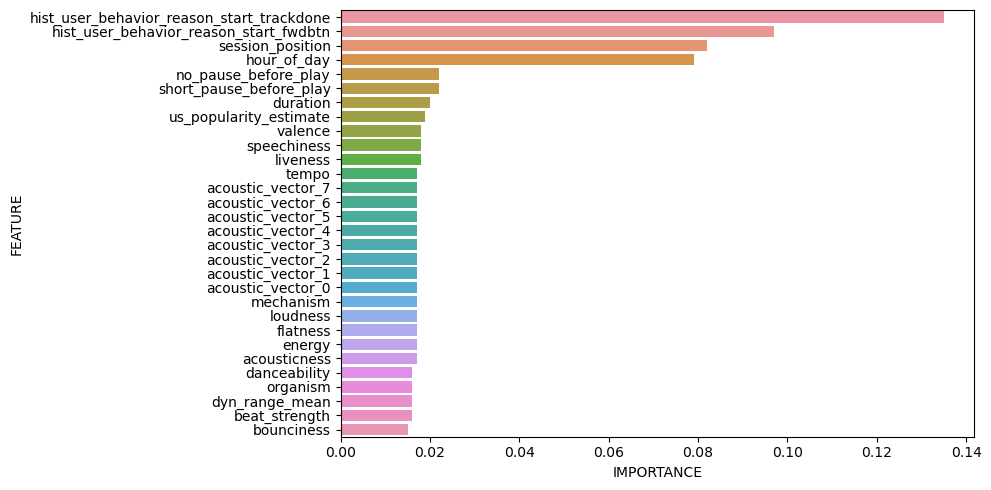

In [38]:
importances = pd.DataFrame({'FEATURE':X_train.columns,'IMPORTANCE':np.round(RF.feature_importances_,3)})
importances = importances.sort_values('IMPORTANCE',ascending=False).set_index('FEATURE')

fig, ax = plt.subplots(figsize=(10,5)) 
sel_range = 30
sns.barplot(y = importances[0:sel_range].index, x = importances['IMPORTANCE'][0:sel_range], orient = 'h', ax = ax)

plt.tight_layout()
plt.show()

# Split each sequence

In [40]:
s_list = df['session_id'].unique()
len(s_list)

10000

In [57]:
data_train_append = []
data_test_append = []
for s_id in s_list:
    temp = []
    temp = df.loc[df['session_id']==s_id,:]
    data_train_append.append(temp.iloc[0:round(len(temp)*0.8),:])
    data_test_append.append(temp.iloc[round(len(temp)*0.8):,:])

data_train = pd.concat(data_train_append)
data_test = pd.concat(data_test_append)

In [58]:
X_train = data_train.drop(columns=['not_skipped', 'skip_1', 'skip_2', 'skip_3', 'session_id','track_id_clean','track_id','date'])
X_test = data_test.drop(columns=['not_skipped', 'skip_1', 'skip_2', 'skip_3', 'session_id','track_id_clean','track_id','date'])

y_train = data_train['not_skipped']
y_test = data_test['not_skipped']

In [59]:
print('Not skipped rate in training dataset: ',y_train.mean())
print('Not skipped rate in testing dataset: ',y_test.mean())

Not skipped rate in training dataset:  0.3192227000163673
Not skipped rate in testing dataset:  0.3877368075061256


In [60]:
RF_sSplit = RandomForestClassifier(random_state=23)
RF_sSplit.fit(X_train, y_train)
score_sSplit_train = RF_sSplit.score(X_train,y_train)
score_sSplit_test = RF_sSplit.score(X_test,y_test)
print('score_train',score_sSplit_train)
print('score_test',score_sSplit_test)

score_train 0.996845566682042
score_test 0.7835415048108528


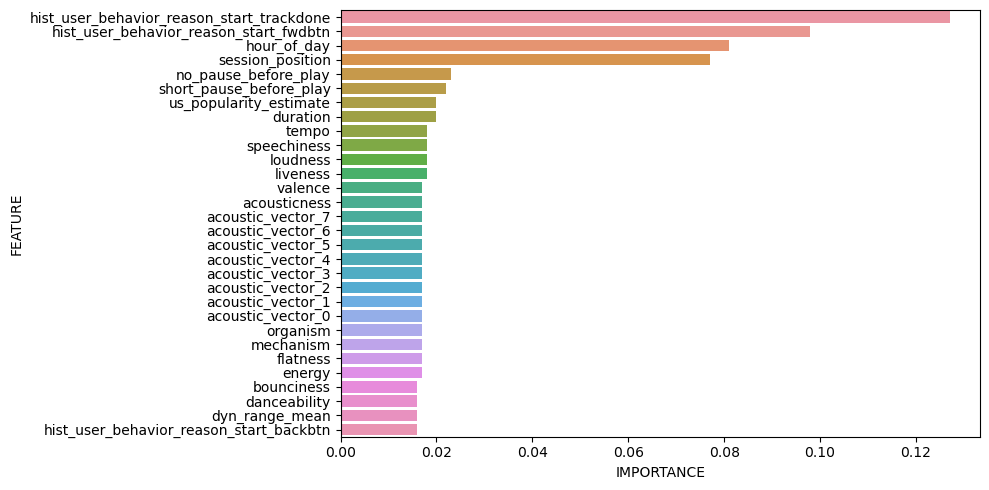

In [61]:
importances = pd.DataFrame({'FEATURE':X_train.columns,'IMPORTANCE':np.round(RF_sSplit.feature_importances_,3)})
importances = importances.sort_values('IMPORTANCE',ascending=False).set_index('FEATURE')

fig, ax = plt.subplots(figsize=(10,5)) 
sel_range = 30
sns.barplot(y = importances[0:sel_range].index, x = importances['IMPORTANCE'][0:sel_range], orient = 'h', ax = ax)

plt.tight_layout()
plt.show()

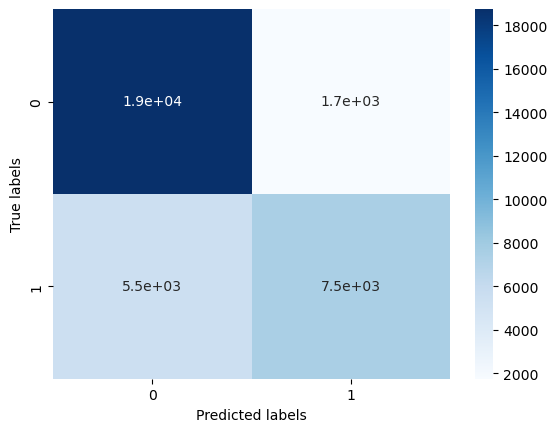

In [62]:
y_test_pred = RF_sSplit.predict(X_test)
pl = confusion_matrix(y_test,y_test_pred)
ax= plt.subplot()
p=sns.heatmap(pl, annot=True,cmap ='Blues',ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');

In [63]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

       False       0.77      0.91      0.84     20490
        True       0.81      0.58      0.67     12976

    accuracy                           0.78     33466
   macro avg       0.79      0.75      0.76     33466
weighted avg       0.79      0.78      0.77     33466



In [64]:
y_train_pred = RF_sSplit.predict(X_train)
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     91506
        True       1.00      0.99      1.00     42908

    accuracy                           1.00    134414
   macro avg       1.00      1.00      1.00    134414
weighted avg       1.00      1.00      1.00    134414



# Split each sequence: multi-class

In [70]:
df['not_skipped']==False

0         False
45        False
50        False
327       False
353       False
          ...  
134522    False
134516    False
134510    False
134504    False
134498    False
Name: not_skipped, Length: 167880, dtype: bool

In [80]:
def skip_label(df):
    skip = (df['not_skipped']==False).astype(int) # no skip: 0
    # It has to go under this order. If skip_1 = True, then skip_2 and _3 will be True too.
    skip[df['skip_3']==True] = 3 
    skip[df['skip_2']==True] = 2
    skip[df['skip_1']==True] = 1
    return skip

#print(skip.head(20))
#print(df[['not_skipped','skip_1','skip_2','skip_3']].head(20))

In [81]:
data_train_append = []
data_test_append = []
for s_id in s_list:
    temp = []
    temp = df.loc[df['session_id']==s_id,:]
    data_train_append.append(temp.iloc[0:round(len(temp)*0.8),:])
    data_test_append.append(temp.iloc[round(len(temp)*0.8):,:])

data_train = pd.concat(data_train_append)
data_test = pd.concat(data_test_append)

X_train = data_train.drop(columns=['not_skipped', 'skip_1', 'skip_2', 'skip_3', 'session_id','track_id_clean','track_id','date'])
X_test = data_test.drop(columns=['not_skipped', 'skip_1', 'skip_2', 'skip_3', 'session_id','track_id_clean','track_id','date'])

y_train = skip_label(data_train)
y_test = skip_label(data_test)

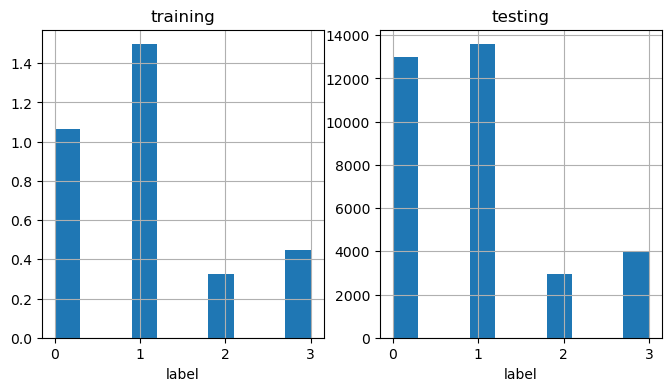

In [94]:
fig, (ax1, ax2) = plt.subplots(figsize=(8,4), ncols=2) 

y_train.hist(ax = ax1, density = True)
ax1.set_xlabel('label')
ax1.title.set_text('training')

y_test.hist(ax = ax2)
ax2.set_xlabel('label')
ax2.title.set_text('testing')

In [83]:
RF_MulClass = RandomForestClassifier(random_state=23)
RF_MulClass.fit(X_train, y_train)
score_MulClass_train = RF_MulClass.score(X_train,y_train)
score_MulClass_test = RF_MulClass.score(X_test,y_test)
print('score_train',score_MulClass_train)
print('score_test',score_MulClass_test)

score_train 0.9945764578094544
score_test 0.6278312316978426


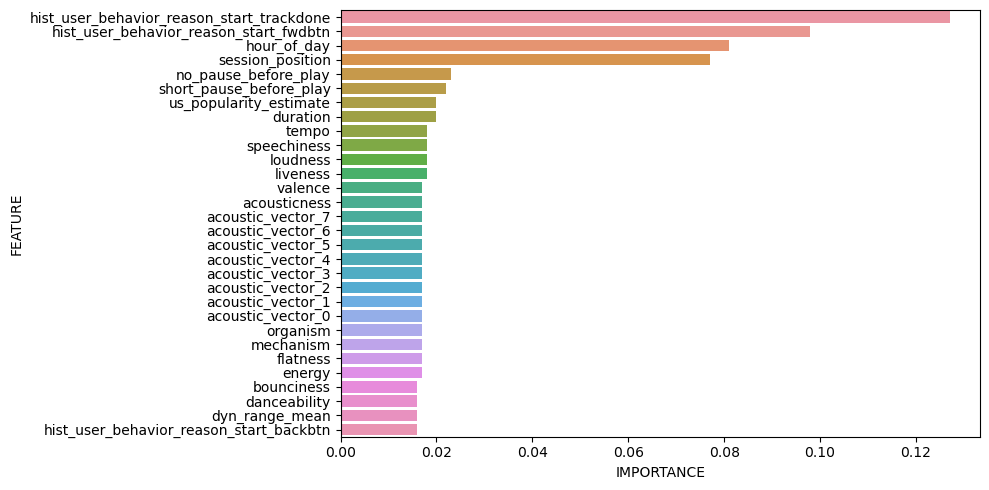

In [84]:
importances = pd.DataFrame({'FEATURE':X_train.columns,'IMPORTANCE':np.round(RF_sSplit.feature_importances_,3)})
importances = importances.sort_values('IMPORTANCE',ascending=False).set_index('FEATURE')

fig, ax = plt.subplots(figsize=(10,5)) 
sel_range = 30
sns.barplot(y = importances[0:sel_range].index, x = importances['IMPORTANCE'][0:sel_range], orient = 'h', ax = ax)

plt.tight_layout()
plt.show()

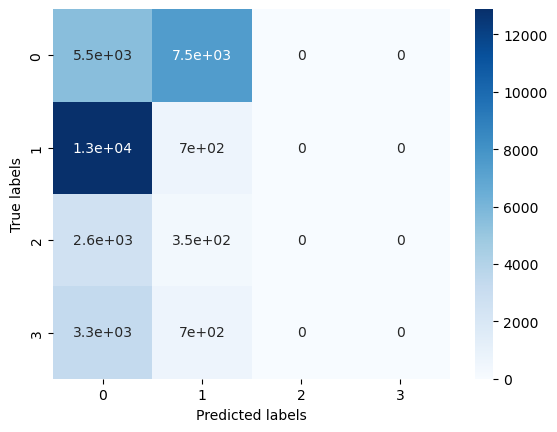

In [85]:
y_test_pred = RF_sSplit.predict(X_test)
pl = confusion_matrix(y_test,y_test_pred)
ax= plt.subplot()
p=sns.heatmap(pl, annot=True,cmap ='Blues',ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');

In [86]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.23      0.42      0.30     12976
           1       0.08      0.05      0.06     13575
           2       0.00      0.00      0.00      2926
           3       0.00      0.00      0.00      3989

    accuracy                           0.19     33466
   macro avg       0.08      0.12      0.09     33466
weighted avg       0.12      0.19      0.14     33466

